In [1]:
import pymongo
import IPython.display as ipd
import pydub
import io
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_client.list_database_names()

['admin', 'config', 'ece590', 'local']

In [3]:
mongo_db = mongo_client['ece590']
mongo_db.list_collection_names()

['filtered_cache']

In [14]:
mongo_collection = mongo_db['filtered_cache']

In [15]:
file_name = '/project/test_file.mp3'

with open( file_name, 'rb' ) as file:
    file_content = file.read()
    
new_entry = {
    'file_name': file_name,
    'filter_edges': [0.0, 0.1, 0.2, 0.5],
    'filter_amplitude': [1., 0.0],
    'file_content': file_content
}
mongo_collection.insert_one( new_entry )

/project/test_file.mp3


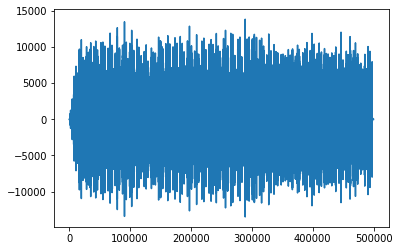

In [17]:
results = mongo_collection.find( { 'filter_amplitude': [1.0, 0.0] } )
for result in results:
    print( result['file_name'] )
    file_content = result.get( 'file_content' )
    if( file_content is not None ):
        sound = pydub.AudioSegment.from_mp3( io.BytesIO( file_content ) )
        samples = sound.get_array_of_samples()
        plt.plot(samples)
        
plt.show()

In [18]:
ipd.Audio(file_content)



In [19]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("ece590") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/ece590.filtered_cache") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/ece590.filtered_cache") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.1') \
    .getOrCreate()

In [21]:
df = spark.read \
    .format("com.mongodb.spark.sql.DefaultSource") \
    .option("database","ece590") \
    .option("collection", "filtered_cache") \
    .load()

In [22]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- file_content: binary (nullable = true)
 |-- file_name: string (nullable = true)
 |-- filter_amplitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- filter_edges: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [23]:
df.drop('file_content').show()

+--------------------+--------------------+----------------+--------------------+
|                 _id|           file_name|filter_amplitude|        filter_edges|
+--------------------+--------------------+----------------+--------------------+
|[5ec1f2a2e90bc693...|/project/test_fil...|      [1.0, 0.0]|[0.0, 0.1, 0.2, 0.5]|
+--------------------+--------------------+----------------+--------------------+



In [24]:
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.sql.types import BooleanType

def list_compare( mongo_list, desired_list ):
    if None is mongo_list:
        return False
    
    if len( mongo_list ) != len( desired_list ):
        return False
    
    for li, le in enumerate( desired_list ):
        if mongo_list[li] != le:
            return False
        
    return True

def udf_list_compare( desired_list ):
    return udf( lambda mongo_list: list_compare( mongo_list, desired_list ), BooleanType() )

df.filter( udf_list_compare( [1.0, 0.0] )( col('filter_amplitude') ) ).drop('file_content').show()

+--------------------+--------------------+----------------+--------------------+
|                 _id|           file_name|filter_amplitude|        filter_edges|
+--------------------+--------------------+----------------+--------------------+
|[5ec1f2a2e90bc693...|/project/test_fil...|      [1.0, 0.0]|[0.0, 0.1, 0.2, 0.5]|
+--------------------+--------------------+----------------+--------------------+



In [25]:
df.filter( udf_list_compare( [0.0, 0.1, 0.2, 0.5] )( col('filter_edges') ) ).drop('file_content').show()

+--------------------+--------------------+----------------+--------------------+
|                 _id|           file_name|filter_amplitude|        filter_edges|
+--------------------+--------------------+----------------+--------------------+
|[5ec1f2a2e90bc693...|/project/test_fil...|      [1.0, 0.0]|[0.0, 0.1, 0.2, 0.5]|
+--------------------+--------------------+----------------+--------------------+



In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

@udf("long")
def apply_filter_to_mp3( mp3_file, filter_edges, filter_amp ):
    sound = pydub.AudioSegment.from_mp3( io.BytesIO( file_content ) )
    samples = sound.get_array_of_samples()
    
    # TODO apply the filter to the MP3 file
    
    print( 'RUNNING FILTER!' )
    print( filter_edges )
    print( filter_amp )
    print( 'DONE RUNNING FILTER!' )
    return len( samples )

df.select(
    'file_content',
    'filter_edges',
    'filter_amplitude',
    apply_filter_to_mp3('file_content', 'filter_edges', 'filter_amplitude').alias('mp3_len')
).drop('file_content').show()

+--------------------+----------------+--------+
|        filter_edges|filter_amplitude| mp3_len|
+--------------------+----------------+--------+
|[0.0, 0.1, 0.2, 0.5]|      [1.0, 0.0]|13982976|
|[0.0, 0.1, 0.2, 0.5]|      [1.0, 0.0]|13982976|
|[0.0, 0.1, 0.2, 0.5]|      [1.0, 0.0]|13982976|
|[0.0, 0.1, 0.2, 0.5]|      [1.0, 0.0]|13982976|
+--------------------+----------------+--------+



In [69]:
from pyspark.sql.functions import udf
import scipy.signal as signal
from pyspark.sql.types import ArrayType, FloatType

@udf(returnType=ArrayType(FloatType()))
def highpass_filter(mp3_file, filter_edges, filter_amp):
    fs=48000
    band = [3000,6000]
    trans_width = 100
    numtaps = 500 
    edges = [0, band[0]-trans_width, band[0], band[1],band[1]+trans_width, 0.5*fs]
    sound = pydub.AudioSegment.from_mp3( io.BytesIO( mp3_file ) )
    samples = sound.get_array_of_samples()
    b = signal.remez(numtaps, edges, [0, 1, 0], Hz=fs)
    final = signal.lfilter(b,1,samples)
    print(type(final))
    return final.tolist()

new_df = df.select(
    'file_content',
    'filter_edges',
    'filter_amplitude',
    highpass_filter('file_content', 'filter_edges', 'filter_amplitude').alias('mp3_len')
).drop('file_content')

In [70]:
sig = np.array(new_df.select('mp3_len').collect()[0]['mp3_len'])
print(type(sig), sig.shape)

<class 'numpy.ndarray'> (499968,)


/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


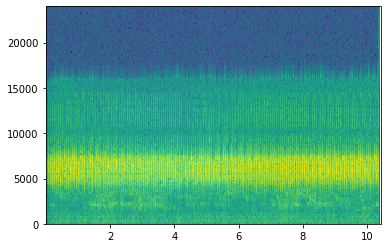

In [67]:
f, t, Sxx = signal.spectrogram(np.array(samples), 48000.0)
plt.pcolormesh(t, f, np.log10(np.abs(Sxx) ))

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


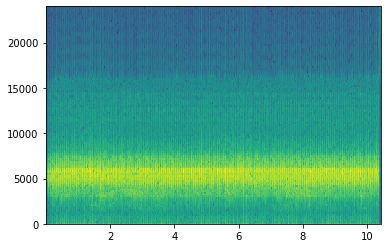

In [71]:
f, t, Sxx = signal.spectrogram(sig, 48000.0)
plt.pcolormesh(t, f, np.log10(np.abs(Sxx) ))
